In [487]:
#importing the libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import nltk
import custom_preprocessor as cp
import featurizer as f
import plot_learning_curve as plc
from sklearn.metrics import classification_report, f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.vocab import  vocab
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR, StepLR
from torch.utils.data import Dataset, DataLoader

import random
from datetime import datetime
import numpy as np
import pandas as pd
import joblib
from collections import Counter
from types import SimpleNamespace
import wandb

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score

In [488]:
wandb.login()

True

In [498]:
#Reading the data 
df=pd.read_excel("dataset.xlsx",sheet_name="data3")

In [499]:
#Converting 10 columns to a single target column
df["target"]=df[["VC1","VC2","VC3","VC4","VC5","VC6","VC7","VC8","VC9","VC10"]].values.tolist()

In [500]:
df.head(2)

,Verbatim,VC1,VC2,VC3,VC4,VC5,VC6,VC7,VC8,VC9,VC10,target
0,Nothing has been resolved. We have been dealin...,RES,TIME,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[RES, TIME, nan, nan, nan, nan, nan, nan, nan,..."
1,Way too long waiting time! Insane to wait 1 h...,TIME,WAIT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[TIME, WAIT, nan, nan, nan, nan, nan, nan, nan..."


In [501]:
df.isnull().sum()

Verbatim    1098
VC1         2676
VC2         5591
VC3         6715
VC4         7361
VC5         7775
VC6         7963
VC7         8074
VC8         8134
VC9         8160
VC10        8166
target         0
dtype: int64

In [502]:
df = df.dropna(subset=["Verbatim"], how="all")


In [503]:
#Preprocessing the verbatim
preprocessor= cp.SpacyPreprocessor(model="en_core_web_sm",lammetize=False, remove_stop=False)
cleaned_text= preprocessor.fit_transform(df["Verbatim"].values)

d:\Intent Modelling\custom_preprocessor.py:40: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  if (bool(BeautifulSoup(text, "html.parser").find())==True):


In [504]:
df["cleaned_text"]=cleaned_text

In [505]:
df.head(1)

,Verbatim,VC1,VC2,VC3,VC4,VC5,VC6,VC7,VC8,VC9,VC10,target,cleaned_text
0,Nothing has been resolved. We have been dealin...,RES,TIME,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[RES, TIME, nan, nan, nan, nan, nan, nan, nan,...",nothing has been resolved we have been dealing...


In [506]:
df1=df[["cleaned_text","target"]]
#df1=df[["Verbatim","target"]]

In [509]:
df1.head(2)

,cleaned_text,target
0,nothing has been resolved we have been dealing...,"[RES, TIME, nan, nan, nan, nan, nan, nan, nan,..."
1,way too long waiting time insane to wait 1 h...,"[TIME, WAIT, nan, nan, nan, nan, nan, nan, nan..."


In [589]:
df1 = df1.dropna(subset=["target"], how="all", inplace=False)

In [592]:
for i, r in df1.head(20).iterrows():
    print(r["target"])

['RES', 'TIME', nan, nan, nan, nan, nan, nan, nan, nan]
['TIME', 'WAIT', nan, nan, nan, nan, nan, nan, nan, nan]
['WARR', nan, nan, nan, nan, nan, nan, nan, nan, nan]
['STORE', nan, nan, nan, nan, nan, nan, nan, nan, nan]
['CREDIT', 'OWN', nan, nan, nan, nan, nan, nan, nan, nan]
['STORE', 'WEB', nan, nan, nan, nan, nan, nan, nan, nan]
['ESC', 'STORE', nan, nan, nan, nan, nan, nan, nan, nan]
['SHPDLV', nan, nan, nan, nan, nan, nan, nan, nan, nan]
['CREDIT', nan, nan, nan, nan, nan, nan, nan, nan, nan]
['GNRL', nan, nan, nan, nan, nan, nan, nan, nan, nan]
['KNOW', nan, nan, nan, nan, nan, nan, nan, nan, nan]
['ORDER', nan, nan, nan, nan, nan, nan, nan, nan, nan]
['PROD', nan, nan, nan, nan, nan, nan, nan, nan, nan]
['PROD', 'TIME', 'WARR', nan, nan, nan, nan, nan, nan, nan]
['PNK', nan, nan, nan, nan, nan, nan, nan, nan, nan]
['HANG', 'TIME', nan, nan, nan, nan, nan, nan, nan, nan]
['ESC', 'STORE', nan, nan, nan, nan, nan, nan, nan, nan]
['MULTI', nan, nan, nan, nan, nan, nan, nan, nan, 

In [591]:
df1 = df1[~(df1["target"].apply(lambda x: x == [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]))]

In [593]:
# Define the target labels
target_labels = [
    'ACC', 'ADV', 'APPT', 'AUTH', 'BILL', 'CANCEL', 'COMM/SOFT', 'CONN', 'CREDIT',
    'CULT', 'DISP', 'DOC', 'EFF', 'ESC', 'GNRL', 'HANG', 'HOLD', 'INV', 'IVR',
    'KNOW', 'LANG', 'LEGAL', 'LOY', 'MISINFO', 'MULTI', 'NOTIFY', 'ORDER', 'OWN',
    'PARTS', 'PAY', 'PCHNL', 'PERM', 'PNK', 'POL', 'PRICE', 'PROC', 'PROD', 'PROF',
    'PRSS', 'RENEW', 'RES', 'RETURN', 'REWARD', 'RSPNS', 'SALES', 'SCRIPT', 'SECURITY',
    'SETEXP', 'SHPDLV', 'STORE', 'SUSP', 'TIME', 'TOOLS', 'TRANSF', 'WAIT', 'WARR',
    'WEB'
]

# Initialize and fit the MultiLabelBinarizer
mlb = MultiLabelBinarizer()
encoded_targets = mlb.fit_transform(df1['target'].apply(lambda x: [label for label in x if label in target_labels]))



In [594]:
X=df1["cleaned_text"]
#X=df1["Verbatim"]
y=encoded_targets

In [595]:
X_train,X_test1,y_train,y_test1=train_test_split(X,y,test_size=0.2,random_state=42)

In [596]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test1, y_test1, test_size= 0.5, random_state= 0)

In [597]:
#Creating a Custom Dataset 
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self,X,y):
        self.X=np.array(X)
        self.y=y
    
    def __len__(self):
        return(len(self.X))
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx=idx.tolist()
        text=self.X[idx]
        labels=self.y[idx]
        sample=(text,labels)
        return sample

In [598]:
type(X_train)

pandas.core.series.Series

In [599]:
train_set=CustomDataset(X_train,y_train)
valid_set=CustomDataset(X_valid,y_valid)
test_Set=CustomDataset(X_test,y_test)


In [600]:
print(len(train_set),len(valid_set),len(test_Set))

3523 441 440


In [601]:
#Vectorizing using tfidf vectorizer
vectorizer=TfidfVectorizer(stop_words="english",min_df=4,max_features=5000).fit(X_train)

In [602]:
X_train_vec=vectorizer.transform(X_train)
X_test_vec=vectorizer.transform(X_test)
X_valid_vec=vectorizer.transform(X_valid)

In [603]:
type(X_train_vec)

scipy.sparse._csr.csr_matrix

In [604]:
#Converting to Tensor
X_train_tensor=torch.tensor(X_train_vec.toarray()).float()
X_valid_tensor=torch.tensor(X_valid_vec.toarray()).float()
X_test_tensor=torch.tensor(X_test_vec.toarray()).float()

In [605]:
y_train_tensor=torch.tensor(np.array(y_train)).long()
y_valid_tensor=torch.tensor(np.array(y_valid)).long()
y_test_tensor=torch.tensor(np.array(y_test)).long()


In [606]:
#Creating a torch dataset
train_set =torch.utils.data.TensorDataset(X_train_tensor,y_train_tensor)
valid_set=torch.utils.data.TensorDataset(X_valid_tensor,y_valid_tensor)
test_set=torch.utils.data.TensorDataset(X_test_tensor,y_test_tensor)

In [607]:
#Creating Model

class Model(nn.Module):

    def __init__(self,input_dim,hidden_dim1,hidden_dim2,output_dim,non_linearity):
        self.input_dim=input_dim
        self.hidden_dim1=hidden_dim1
        self.hidden_dim2=hidden_dim2
        self.output_dim=output_dim
        self.non_linearity=non_linearity

        super().__init__()

        #hidden layer1
        self.hidden_layer1=nn.Linear(self.input_dim,self.hidden_dim1)
        #hidden layer2
        self.hidden_layer2=nn.Linear(self.hidden_dim1,self.hidden_dim2)
        #output layer
        self.output_layer=nn.Linear(self.hidden_dim2,self.output_dim)

    def forward(self,input):
        hout1=self.non_linearity(self.hidden_layer1(input))
        hout2=self.non_linearity(self.hidden_layer2(hout1))
        ypred=self.output_layer(hout2)

        return ypred

In [608]:
#Training model for each epoch 
def train(train_loader, model,optimizer,loss_function,log_batch,log_interval,grad_clipping,max_norm):

    #initializing variable as global 
    #Count will be updated for every epoch
    global example_ct_train
    global batch_ct_train

    #Training loop 
    #Initializing the train_loss at the the start of the epoch
    running_train_loss=0

    #Put model in training mode
    model.train()

    #Iterate on batches from the dataset using train_loader
    for input,targets in train_loader:
        # move inputs and outputs to GPUs
        input = input.to(device)
        targets = targets.to(device)

        #Forward pass
        output=model(input)
        loss=loss_function(output,targets.float())

        example_ct_train += len(targets)
        batch_ct_train+=1

        #set gradients to zero
        optimizer.zero_grad()

        #backward pass
        loss.backward()

        #Gradient clipping
        if grad_clipping:
            nn.utils.clip_grad_norm(model.parameters(),max_norm=max_norm,norm_type=2)

        #Update the parameters using their gradients
        optimizer.step()

        running_train_loss += loss.item()

        if log_batch:
            if((batch_ct_train+1) % log_interval)==0:
                wandb.log({f"Train Batch Loss: ":loss})
    
    #Calculate the mean train loss for the whole dataset for a particular epoch
    train_loss = running_train_loss/len(train_loader)

    return train_loss



In [609]:
def valid(loader,model,optimizer,loss_function,log_batch,log_interval):

    #initialize variable as global
    # these counts will be updated every epoch
    global example_ct_valid
    global batch_ct_valid

    #Validation Loop 
    #Intialize train_loss at the start of the epoch
    running_valid_loss = 0

    #put model in the evaluation mode
    model.eval()

    with torch.no_grad():
        for input,targets in loader:

            # move inputs and outputs to GPUs
            input = input.to(device)
            targets = targets.to(device)   

            #Forward pass
            output=model(input)
            loss=loss_function(output,targets.float())

            #count of images and batches 
            example_ct_valid += len(targets)
            batch_ct_valid +=1

            #Add valid loss of a batch
            running_valid_loss +=loss.item()

            #log batch loss and accuracy
            if log_batch:
                if ((batch_ct_valid + 1) % log_interval) == 0:
                    wandb.log({f"Valid Batch Loss :": loss})

            #Calculate mean valid loss for the whole dataset for particular epoch
            valid_loss = running_valid_loss/len(loader)

        return valid_loss


In [610]:
#Defining the training loop

def train_loop(train_loader,valid_loader, model,loss_function,optimizer, epochs,device, patience, early_stopping, file_model):
     '''
  model: specify your model for training
  criterion: loss function 
  optimizer: optimizer like SGD , ADAM etc.
  train loader: function to carete batches for training data
  valid loader : function to create batches for valid data set
  file_model : specify file name for saving your model. This way we can upload the model weights from file. We will not to run model again.
  

  '''
     #Create a list to store the train and valid loss at each epoch
     train_loss_history = []
     valid_loss_history=[]

     delta=0
     best_score=None
     valid_loss_min =np.Inf
     counter_early_stop=0
     early_stop=False


     #Iterate for a given number of epochs 
     for epoch in range(epochs):
          t0=datetime.now()

          #Get train loss and accuracy for one epoch

          train_loss= train(train_loader,model,optimizer, loss_function,wandb.config.LOG_BATCH,wandb.config.LOG_INTERVAL,wandb.config.GRAD_CLIPPING,wandb.config.MAX_NORM)

          valid_loss= valid(valid_loader, model, optimizer, loss_function,wandb.config.LOG_BATCH,wandb.config.LOG_INTERVAL)

          dt=datetime.now()-t0

          #Save history of losses and accuracy
          train_loss_history.append(train_loss)

          valid_loss_history.append(valid_loss)

          if early_stopping:
               score= -valid_loss
               if best_score is None:
                    best_score=score
                    print(f'Validation loss has decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving Model..')
                    torch.save(model.state_dict(),file_model)
                    valid_loss_min=valid_loss

               elif score<best_score+delta:
                     counter_early_stop+=1
                     print(f"Early Stopping counter: {counter_early_stop} out of {patience}")
                     if counter_early_stop > patience:
                          early_stop=True

               else:
                    best_score=score
                    print(f"Validationn loss had decreased ({valid_loss_min:.6f}) --> {valid_loss:.6f}). Saving model.. ")
                    torch.save(model.state_dict(),file_model)
                    counter_early_stop=0
                    valid_loss_min=valid_loss
               
               if early_stop:
                    print("Early Stopping")
                    break
          else:
               score = -valid_loss
               if best_score is None:
                    best_score=score
                    print(f"Validation loss has decreased ({valid_loss_min:.6f}) --> {valid_loss:.6f}). Saving Model..")
                    torch.save(model.state_dict(),file_model)
                    valid_loss_min=valid_loss

               elif score<best_score+delta:
                    print(f"Validation score has not decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Not Saving Model..")

               else:
                    best_score = score
                    print(f"Validation loss has decreased ({valid_loss_min:.6f}--> {valid_loss:.6f}). Saving Model")
                    torch.save(model.state_dict(),file_model)
                    valid_loss_min=valid_loss

          #Log the train and valid loss to W&B
          wandb.log({f"Train epoch loss:":train_loss, f"Valid epoch Loss :":valid_loss})

          #Print the train loss and accuracy for given number of epochs, batch size and number of samples
          print(f"Epochs : {epoch+1} / {epochs}")
          print(f"Time to complete {epoch+1} is {dt}")

          print(f"Train loss:  {train_loss: .4f}")

          print(f"Valid lodd: {valid_loss : .4f}")

          print()

          torch.cuda.empty_cache()
      
     return train_loss_history, valid_loss_history
               

                    
               
            
               
               

          

In [618]:
#Hyperparameters
hyperparameters= SimpleNamespace(
    INPUT_DIM = train_set.tensors[0].shape[1],
    OUTPUT_DIM = 47,
    HIDDEN_DIM1 = 512,
    HIDDEN_DIM2 = 256,
    NON_LINEARITY= F.relu,
    EPOCHS = 40,
    
    BATCH_SIZE = 256,
    LEARNING_RATE = 0.01,
    DATASET="Multilabel",
    ARCHITECTUREe="IntentModelling",
    LOG_INTERVAL = 25,
    LOG_BATCH = True,
    FILE_MODEL = 'IntentModel.pt',
    GRAD_CLIPPING = False,
    MAX_NORM = 0,
    MOMENTUM = 0,
    PATIENCE = 5,
    EARLY_STOPPING = True,
    # SCHEDULER_FACTOR = 0,
    # SCHEDULER_PATIENCE = 0,
    WEIGHT_DECAY = 0

)

In [619]:
#Initialize new Project 
import random
wandb.init(name="Intent Modelling", project="NLP")


In [620]:
wandb.config=hyperparameters
non_linearity=F.relu
wandb.Config.NON_LINEARITY = non_linearity

In [621]:
wandb.Config

wandb.sdk.wandb_config.Config

In [622]:
#Fix seed value 
SEED=1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic=True

#DATA Loaders
train_loader=torch.utils.data.DataLoader(train_set,batch_size=wandb.config.BATCH_SIZE,shuffle=True,num_workers=4)
valid_loader=torch.utils.data.DataLoader(valid_set,batch_size=wandb.config.BATCH_SIZE,shuffle=True,num_workers=4)
test_loader=torch.utils.data.DataLoader(test_Set,batch_size=wandb.config.BATCH_SIZE,shuffle=True,num_workers=4)

#Cross entropy loss function
loss_function= nn.BCEWithLogitsLoss()

#use GPU
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
wandb.config.DEVICE=device

#Model
model=Model(wandb.config.INPUT_DIM, wandb.config.HIDDEN_DIM1, wandb.config.HIDDEN_DIM2, wandb.config.OUTPUT_DIM, wandb.config.NON_LINEARITY)

model.to(wandb.config.DEVICE)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)

#Apply initialization recursively to all modules
model.apply(init_weights)

#Initialize stochiastic gradient descent optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=wandb.config.LEARNING_RATE,weight_decay=wandb.config.WEIGHT_DECAY)

wandb.config.OPTIMIZER = optimizer



In [623]:
#Sanity Check 
for input_, targets in train_loader:
  
  # move inputs and outputs to GPUs
  input_ = input_.to(device)
  targets = targets.to(device)
  model.eval()
  # Forward pass
  output = model(input_)
  loss = loss_function(output, targets.float())
  print(f'Actual loss: {loss}')
  break

print(f'Expected Theoretical loss: {np.log(2)}')

Actual loss: 0.6940403580665588
Expected Theoretical loss: 0.6931471805599453


In [624]:
#Training model
wandb.watch(model, log = 'all', log_freq=25, log_graph=True)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [625]:
example_ct_train,batch_ct_train, example_ct_valid,batch_ct_valid = 0, 0, 0, 0

train_loss_history, valid_loss_history = train_loop(train_loader, valid_loader, 
                                                                                          model,
                                                                                          loss_function, 
                                                                                          optimizer, 
                                                                                          wandb.config.EPOCHS, 
                                                                                          wandb.config.DEVICE,
                                                                                          wandb.config.PATIENCE, 
                                                                                          wandb.config.EARLY_STOPPING,
                                                                                          wandb.config.FILE_MODEL)

Validation loss has decreased (inf --> 0.160976). Saving Model..
Epochs : 1 / 40
Time to complete 1 is 0:00:08.029995
Train loss:   0.2679
Valid lodd:  0.1610

Validationn loss had decreased (0.160976) --> 0.133566). Saving model.. 
Epochs : 2 / 40
Time to complete 2 is 0:00:08.325032
Train loss:   0.1484
Valid lodd:  0.1336

Validationn loss had decreased (0.133566) --> 0.111194). Saving model.. 
Epochs : 3 / 40
Time to complete 3 is 0:00:08.712187
Train loss:   0.1137
Valid lodd:  0.1112

Validationn loss had decreased (0.111194) --> 0.098767). Saving model.. 
Epochs : 4 / 40
Time to complete 4 is 0:00:08.838708
Train loss:   0.0806
Valid lodd:  0.0988

Validationn loss had decreased (0.098767) --> 0.094533). Saving model.. 
Epochs : 5 / 40
Time to complete 5 is 0:00:08.768711
Train loss:   0.0521
Valid lodd:  0.0945

Early Stopping counter: 1 out of 5
Epochs : 6 / 40
Time to complete 6 is 0:00:08.798331
Train loss:   0.0303
Valid lodd:  0.1025

Early Stopping counter: 2 out of 5
Epo

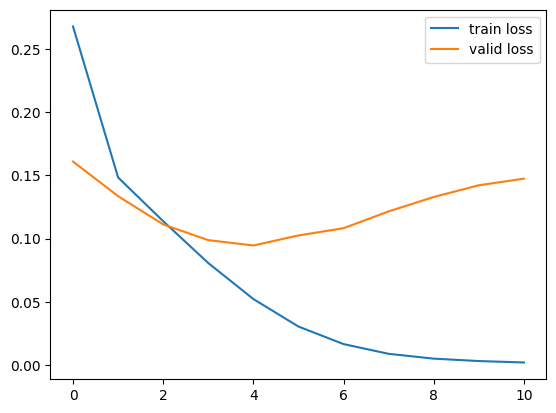

In [626]:
#LOSS PLOT
# Plot the train loss and test loss per iteration
import matplotlib.pyplot as plt 
fig = plt.figure(0)
plt.plot(train_loss_history, label = 'train loss')
plt.plot(valid_loss_history, label = 'valid loss')
plt.legend()

# Log the plot to W&B
wandb.log({"train-test loss per epoch": wandb.Image(plt)})

In [627]:
model_nn = Model(wandb.config.INPUT_DIM, wandb.config.HIDDEN_DIM1, wandb.config.HIDDEN_DIM2, wandb.config.OUTPUT_DIM, non_linearity)
model_nn.to(device)
model_nn.load_state_dict(torch.load(wandb.config.FILE_MODEL))

<All keys matched successfully>

In [566]:
#wandb.finish()

In [628]:
def evaluate_model(data_loader, model, device):
    """ 
    Function to evaluate the performance of a given model on a dataset
    Input: Data iterator, Model, Device (CPU or GPU)
    Output: Predictions, Actual labels, Classification report, F1 score
    """
    # Array to store predicted labels
    predictions = torch.Tensor().to(device)

    # Array to store actual labels
    y_true = torch.Tensor().to(device)

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for input_, targets in data_loader:
            input_ = input_.to(device)
            targets = targets.to(device)

            output = model(input_)
            prediction = torch.sigmoid(output)
            indices = (prediction >= 0.5).float()  # Threshold predictions

            # Add the predicted labels to the array
            predictions = torch.cat((predictions, indices))

            # Add the actual labels to the array
            y_true = torch.cat((y_true, targets))

    # Convert tensors to numpy arrays
    predictions = predictions.cpu().numpy()
    y_true = y_true.cpu().numpy()

    # Generate classification report
    report = classification_report(y_true, predictions, target_names=["class1", "class2", ...])

    # Calculate F1 score
    f1 = f1_score(y_true, predictions, average="weighted")

    return predictions, y_true, report, f1

In [629]:
##Function for Accuracy

def get_acc_pred(data_loader, model,device):
    
  """ 
  Function to get predictions and accuracy for a given data using estimated model
  Input: Data iterator, Final estimated weoights, bias
  Output: Precditions and Accuracy for given dataset
  """

  # Array to store predicted labels
  predictions = torch.Tensor() # empty tensor
  predictions = predictions.to(device) # move predictions to GPU

  # Array to store actual labels
  y = torch.Tensor() # empty tensor
  y = y.to(device)

  total=0
  correct=0
  # Iterate over batches from data iterator
  with torch.no_grad():
    for input_, targets in data_loader:
      
      # move inputs and outputs to GPUs
      
      input_ = input_.to(device)
      targets = targets.to(device)
      
      # Calculated the predicted labels
      output = model(input_)

      # Choose the label with maximum probability
      prediction = torch.sigmoid(output)
      indices=prediction
      indices[indices>0.5]=1
      indices[indices<0.5]=0

      # Add the predicted labels to the array
      predictions = torch.cat((predictions, indices)) 

      # Add the actual labels to the array
      y = torch.cat((y, targets))

      predicted = np.round(prediction) #keep in mind that np.round() is a round to even function
      total += targets.size(0)
      #print("Target: ",targets.size(0))
      #print("Predicted: ",predicted)
      #print("Target: ", targets)
      #calculate how many images were correctly classified
      correct += (predicted == targets).sum().item()
      #print(correct)
  accuracy=100.0* (correct/total)
  print("Accuracy: {}%".format(accuracy))
  # Check for complete dataset if actual and predicted labels are same or not
  # Calculate accuracy
  #acc = (predictions == y).float().mean()

  # Return tuple containing predictions and accuracy
  return predictions, y

In [630]:
#Function for predictions
def get_predictions(data_loader, model,device):
    # Array to store predicted labels
    predictions = torch.Tensor() # empty tensor
    predictions = predictions.to(device) # move predictions to GPU

    with torch.no_grad():
        for input_ in data_loader:
        
            # move inputs and outputs to GPUs
        
            input_ = input_.to(device)
            #targets = targets.to(device)
            
            # Calculated the predicted labels
            output = model(input_)

            # Choose the label with maximum probability
            prediction = torch.sigmoid(output)
            indices=prediction
            indices[indices>0.5]=1
            indices[indices<0.5]=0

            # Add the predicted labels to the array
            predictions = torch.cat((predictions, indices)) 
        return predictions
    

In [631]:
pred_train, y_train = get_acc_pred(train_loader, model_nn, device)

Accuracy: 4649.560034061879%


In [632]:
#predictions, y_true, report, f1 = evaluate_model(train_loader, model_nn, device)

In [633]:
print("Weighted F1 score: {:.2f}".format(f1_score(y_true= y_train, y_pred= pred_train, average= 'weighted')))

Weighted F1 score: 0.83


In [634]:
#making predictions
#Converting to Tensor
test=pd.read_excel("dataset.xlsx",sheet_name="data4")

test_cleaned_text= preprocessor.transform(test["Verbatim"].values)
test_cleaned_vec=vectorizer.transform(test_cleaned_text)

test_cleaned_tensor=torch.tensor(test_cleaned_vec.toarray()).float()

d:\Intent Modelling\custom_preprocessor.py:40: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  if (bool(BeautifulSoup(text, "html.parser").find())==True):


In [635]:
pred_loader=torch.utils.data.DataLoader(test_cleaned_tensor,batch_size=wandb.config.BATCH_SIZE,shuffle=False,num_workers=4)

In [636]:
result=get_predictions(pred_loader,model_nn,device)

In [637]:
len(result)

132

In [638]:
test["predictions"]=mlb.inverse_transform(result)

In [639]:
test.head()

,Verbatim,predictions
0,Javier was great but was clear that his hands ...,"(PROD,)"
1,my problem has to do with my veterans discount...,"(LANG,)"
2,If you ship me a broken product I should not h...,"(GNRL, TIME, WAIT)"
3,It was disappointing to receive the item in su...,"(GNRL, STORE)"
4,Allow an online or chat version for people tha...,"(KNOW,)"


In [640]:
count=0
for i in test["predictions"]:
    if "GNRL" in i:
        count+=1

In [647]:
test[test["predictions"]!=()].to_csv("ModelGeneratedResponse.csv")